# Big Data Platform
## Assignment 3: ServerLess

**By:**  

Or Livne, 300123123  
Roy Rubin, 201312907

<br><br>

**The goal of this assignment is to:**
- Understand and practice the details of Serverless

**Instructions:**
- Students will form teams of two people each, and submit a single homework for each team.
- The same score for the homework will be given to each member of your team.
- Your solution is in the form of a Jupyter notebook file (with extension ipynb).
- Images/Graphs/Tables should be submitted inside the notebook.
- The notebook should be runnable and properly documented. 
- Please answer all the questions and include all your code.
- You are expected to submit a clear and pythonic code.
- You can change functions signatures/definitions.

**Submission:**
- Submission of the homework will be done via Moodle by uploading (not Zip):
    - Jupyter Notebook
    - 2 Log files
    - Additional local scripts
- The homework needs to be entirely in English.
- The deadline for submission is on Moodle.
- Late submission won't be allowed.

  
- In case of identical code submissions - both groups will get a Zero. 
- Some groups might be selected randomly to present their code.

**Requirements:**  
- Python 3.6 should be used.  
- You should implement the algorithms by yourself using only basic Python libraries (such as numpy,pandas,etc.)

<br><br><br><br>

**Grading:**
- Q0 - 10 points - Setup
- Q1 - 40 points - Serverless MapReduceEngine
- Q2 - 20 points - MapReduce job to calculate inverted index
- Q3 - 30 points - Shuffle

`Total: 100`

<br><br>

# Question 0
## Setup

1. Navigate to IBM Cloud and open a trial account. No need to provide a credit card
2. Choose IBM Cloud Object Storage service from the catalog
3. Create a new bucket in IBM Cloud Object Storage
4. Create credentials for the bucket with HMAC (access key and secret key)
5. Choose IBM Cloud Functions service from the catalog and create a service


#### Lithops setup
1. By using “git” tool, install master branch of the Lithops project from
https://github.com/lithops-cloud/lithops
2. Follow Lithops documentation and configure Lithops against IBM Cloud Functions and IBM Cloud Object Storage
3. Configure Lithops log level to be in DEBUG mode
4. Run Hello World example by using Futures API and verify all is working properly.


#### IBM Cloud Object Storage setup
1. Upload all the input CSV files that you used in homework 2 into the bucket you created in IBM Cloud Object Storage


<br><br><br>

# Question 1
## Serverless MapReduceEngine

Modify MapReduceEngine from homework 2 into the MapReduceServerlessEngine where map and reduce tasks executed as a serverless actions, instead of local threads. In particular:
1. Deploy all map tasks as a serverless actions by using Lithops against IBM Cloud Functions.
2. Collect results from all map tasks and store them in the same SQLite as you used in MapReduceEngine and use the same code for the sort and shuffle phase.
3. Deploy reduce tasks by using Lithops against IBM Cloud Functions. Instead of persisting results from reduce tasks, return results back to the MapReduceServerlessEngine and proceed with the same workflow as in MapReduceEngine
4. Return results of reduce tasks to the user

**Please attach:**  
Text file with all log messages Lithops printed to console during the execution. Make
sure log level is set to DEBUG mode.

#### Code:

## Imports

In [1]:
import glob
import os
import sqlite3
from io import StringIO, BytesIO

import lithops
import numpy as np
import pandas as pd
from lithops import Storage


# set our IBM configurations
* can be replace by checker configuration by this format

In [2]:
global_config = {
                    'lithops': 
                        {
                        'backend': 'ibm_cf',
                        'storage': 'ibm_cos',
                        'log_level': 'DEBUG'
                        },
                    'ibm_cf': 
                        {
                        'endpoint': 'https://us-south.functions.cloud.ibm.com',
                        'namespace': 'roy.rubin@post.idc.ac.il_dev',
                        'api_key': '1defbac0-eea1-4bb8-b5d4-cee7e63b3bb4:63a0ls32DAGjVe0TkdUcBqcOL7lOtR7bLsQYf98WGgW2xpp9Bpd0BUSubnlsfNQM',
                        },
                    'ibm_cos': 
                        {
                        'storage_bucket': 'cloud-object-storage-mq-cos-standard-8s4',
                        'region': 'eu-de',
                        "access_key": "bb21b4d35ef046d19b4f6fd93f39a3a5",
                        "secret_key": "d9db9b67564ec2fc5467820ef8719533cdc2e64a5ce33695",
                        }
                }

# Set our main functions

In [11]:
def init_configurations():
    # Set the value options
    global max_rows, csv_columns, db_file_name, csv_file_name, columns_type
    global csv_index, csv_ending, amount_of_files
    global map_reduce_folder_names, amount_of_process, map_regex, db_columns
    global db_columns_type, db_table_name, reduce_regex_init, reduce_regex_final

    Current_python_file_path = os.getcwd()
    max_rows = 10
    amount_of_files = 20
    amount_of_process = 2
    csv_columns = ['firstname', 'secondname', 'city']
    db_columns = ['key', 'value']
    map_reduce_folder_names = [os.path.join(Current_python_file_path, 'mapreducetemp'),
                               os.path.join(Current_python_file_path, 'mapreducefinal')]

    db_columns_type = ['text', 'text']

    db_file_name = 'mydata.db'
    csv_file_name = 'myCSV'
    csv_ending = '.csv'
    map_regex = 'part-tmp-'
    reduce_regex_init = 'part-'
    reduce_regex_final = '-final'

    db_table_name = 'temp_results'

    return


def inverted_map(document_name: str):
    try:
        # Preparations
        storage = Storage(config=global_config)
        data = storage.get_object(global_config['ibm_cos']['storage_bucket'], document_name)

        # Begin
        csv_df = pd.read_csv(BytesIO(data), encoding='utf8', sep=",", index_col=0)
        csv_size = csv_df.shape[0]
        csv_columns = csv_df.columns.to_list()
        output_list = []
        for i_col in csv_columns:
            col_vals = csv_df[i_col].to_list()
            curr_ouput = list(map(lambda x, y, z: (x + '_' + y, z), csv_size * [i_col], col_vals, csv_size * [document_name]))
            output_list += curr_ouput

    except Exception as exception:
        return [], False

    return output_list, True


def inverted_reduce(data):
    try:
        value, documents = data
        ducument_name_list = documents.split(',')
        ducument_name_list_no_duplicates = list(set(ducument_name_list))
        string_ducument_name_list_no_duplicates = (', ').join(ducument_name_list_no_duplicates)
        return_list = [value, string_ducument_name_list_no_duplicates]

    except Exception as exception:
        return [], False

    return return_list, True
def write_list_to_txt_file(path, List):
    with open(path, 'w') as f:
        for item in List:
            f.write("%s\n" % item)
    f.close()
    return


class MapReduceServerlessEngine(object):
    def __init__(self):
        # create a function executor
        self._fexec = lithops.FunctionExecutor(config=global_config)

    def execute(self, input_data, map_function, reduce_function):
        """
        execute map and reduce

        :param input_data: assumption: given as:     input_data = 'cos://bucket/<path to CSV data>'
        :param map_function:
        :param reduce_function:
        :return:
        """
        #  1) For each key  from the  input_data, start a new Python thread that executes
        #     map_function(key)
        #  2) Each serverless action will store results of the map_function into
        #     mapreducetemp/part-tmp-X.csv where X
        #     is a unique number per each thread.
        #  3) Keep the list of all severless tasks and check whether they are completed

        region, bucket_name, extra = self._parse_input_data(input_data)
        self._bucket_name = global_config['ibm_cos']['storage_bucket']

        curr_config = global_config
        self._storage = Storage(config=curr_config)

        list_of_objects = self._storage.list_objects(bucket=bucket_name)
        list_of_csv_objects = [item for item in list_of_objects if '.csv' in item['Key']]
        list_of_csv_names = [item['Key'] for item in list_of_csv_objects if '.csv' in item['Key']]

        # call function async-ly
        response_list = []
        for csv_name in list_of_csv_names:
            response = self._fexec.call_async(func=map_function, data={'document_name': csv_name})
            response_list.append(response)

        try:
            results = self._fexec.get_result(fs=response_list)  # internally calls wait. note: if one fails, all fails !
            self._fexec.clean()
        except Exception as exception:
            status = 'Map Reduce Failed'
            return status

        # get all map logs
        map_loglist = list(map(lambda x: x.logs, response_list))
        
        # get list of succeed or failed of severless tasks
        boolean_results = [boolean for output, boolean in results]

        # validate that all severless tasks are completed succesfully
        if False in boolean_results:
            status = 'Map Reduce Failed'
            return status

        # 4) Once all severless tasks completed, load content of all CSV files into the temp_results
        #    table in SQLite

        # get new files names
        outputs = [output for output, boolean in results]

        # write generated csv files to sql data base
        sql_conn = sqlite3.connect(db_file_name)
        for output in outputs:
            result_df = pd.DataFrame(data=output, columns=['key', 'value'])
            result_df.to_sql('temp_results', sql_conn, if_exists='append', index=False)

        # dont forget to close connection after finishing
        sql_conn.close()

        # 5) **Write SQL statement** that generates a sorted list by key of the form
        #    `(key, value)` where value is concatenation of ALL values in the value column
        #     that match specific key. For example, if table has records

        # query data base using GROUP_CONCAT and GROUP BY  and ORDER BY
        generated_list = self._get_grouped_info_from_db_by_key(key='key')

        # 6) **Start a new thread** for each value from
        #    the generated list in the previous step, to execute `reduce_function(key,value)
        #    Begin by Performing REDUCE actions
        #    we will open a thread for each REDUCE
        # 7) Each thread will store results of reduce_function into
        #   `mapreducefinal/part-X-final.csv` file

        # 8) Keep list of all severless tasks and check whether they are completed

        # call function async-ly
        response_list = []
        for item in generated_list:
            response = self._fexec.call_async(func=reduce_function, data={'data': item})
            response_list.append(response)

        try:
            results = self._fexec.get_result(fs=response_list)  # internally calls wait. note: if one fails, all fails !
            self._fexec.clean()
        except Exception as exception:
            status = 'Map Reduce Failed'
            return status

        # 9) Once all severless tasks completed, print on the screen
        #   `MapReduce Completed` otherwise print `MapReduce Failed`
        
        # get all reduce logs
        reduce_loglist = list(map(lambda x: x.logs, response_list))

        # get list of succeed or failed of severless tasks
        boolean_results = [boolean for output, boolean in results]

        # validate that all severless tasks are completed succesfully
        if False in boolean_results:
            status = 'Map Reduce Failed'
            return status
        log_seprator = '----------------------------------'
        map_and_reduce_logs = [log_seprator+ 'Map log' + log_seprator] + map_loglist + reduce_loglist + [log_seprator+'Reduce log' +log_seprator]
        write_list_to_txt_file('map_reduce_log_file.txt',map_and_reduce_logs )
        outputs = [output for output, boolean in results]
        reduce_df = pd.DataFrame(data=outputs, columns = ['feature&value', 'Files names'])
        return reduce_df


    def _get_grouped_info_from_db_by_key(self, key):
        con = sqlite3.connect(db_file_name)
        cur = con.cursor()
        return_list = []
        for row in cur.execute(
                'SELECT key, GROUP_CONCAT(value) FROM ' + db_table_name + ' GROUP BY ' + key + ' ORDER BY ' + key):
            # print(row)
            return_list.append(row)
        con.close()
        return return_list

    def _parse_input_data(self, input_data: str):
        """

        :param input_data: assumption: format is something like :  input_data = 'cos://eu-de/cloud-object-storage-mq-cos-standard-8s4/myCSV0.csv'
        :return:
        """

        if input_data is None or input_data == '':
            raise AssertionError(f'Bad arguments passed: input_data is None or input_data == ''')

        parts = input_data.split(sep='cos://')[1].split(sep='/')

        region = parts[0]
        bucket = parts[1]
        extra = parts[2:]

        return region, bucket, extra

# Task 2
## Submit MapReduce job to calculate inverted index
1. Use input_data: `cos://bucket/<path to CSV data>`
2. Submit MapReduce job with reduce and map functions as you used in homework 2, as follows

    `mapreduce = MapReduceServerlessEngine()`  
    `results = mapreduce.execute(input_data, inverted_map, inverted_index)`   
    `print(results)`

**Please attach:**  
Text file with all log messages Lithops printed to console during the execution. Make
sure log level is set to DEBUG mode.

#### Code:

In [12]:
# Prepare
init_configurations()

# input_data = 'cos://eu-de/cloud-object-storage-mq-cos-standard-8s4/'
separator = '/'
ibm_intro = 'cos://'
extra_path = ''
input_data = ibm_intro + global_config['ibm_cos']['region'] + separator + global_config['ibm_cos']['storage_bucket'] + separator
print(f'input_data:\n{input_data}')

# Run
mapreduce = MapReduceServerlessEngine()
result = mapreduce.execute(input_data, inverted_map, inverted_reduce)


2022-01-09 14:46:45,402 [INFO] lithops.config -- Lithops v2.5.8
2022-01-09 14:46:45,404 [DEBUG] lithops.config -- Loading Serverless backend module: ibm_cf
2022-01-09 14:46:45,406 [DEBUG] lithops.config -- Loading Storage backend module: ibm_cos
2022-01-09 14:46:45,407 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- Creating IBM COS client
2022-01-09 14:46:45,408 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- Set IBM COS Endpoint to https://s3.eu-de.cloud-object-storage.appdomain.cloud
2022-01-09 14:46:45,408 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- Using access_key and secret_key
2022-01-09 14:46:45,414 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS client created - Region: eu-de
2022-01-09 14:46:45,415 [DEBUG] lithops.serverless.backends.ibm_cf.ibm_cf -- Creating IBM Cloud Functions client
2022-01-09 14:46:45,417 [DEBUG] lithops.serverless.backends.ibm_cf.ibm_cf -- Set IBM CF Namespace to roy.rubin@post.idc.ac.il_dev
2022-01-09 14:46:45,417 [DEBUG] lit

input_data:
cos://eu-de/cloud-object-storage-mq-cos-standard-8s4/


2022-01-09 14:46:46,134 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A000 - Selected Runtime: lithopscloud/ibmcf-python-v37 - 256MB
2022-01-09 14:46:46,135 [DEBUG] lithops.storage.storage -- Runtime metadata found in local memory cache
2022-01-09 14:46:46,136 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A000 - Serializing function and data
2022-01-09 14:46:46,141 [DEBUG] lithops.job.serialize -- Referenced modules: C:\Users\or livne\AppData\Roaming\Python\Python37\site-packages\lithops\storage\storage.py, _io, C:\Users\or livne\anaconda_app\envs\Or\lib\site-packages\pandas\__init__.py
2022-01-09 14:46:46,141 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:46:46,143 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A000 - Uploading function and modules to the storage backend
2022-01-09 14:46:46,753 [DEBUG] lithops.storage.backends.ibm_cos.ibm_cos -- PUT Object lithops.jobs/912e8f-2/dfb32a4c87ccdd9c4b062c7383e9fa0b.func.pickle - Size: 1.7

2022-01-09 14:46:46,875 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A004 - View execution logs at C:\Users\or livne\AppData\Local\Temp\lithops\logs\912e8f-2-A004.log
2022-01-09 14:46:46,877 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A005 - Selected Runtime: lithopscloud/ibmcf-python-v37 - 256MB
2022-01-09 14:46:46,878 [DEBUG] lithops.storage.storage -- Runtime metadata found in local memory cache
2022-01-09 14:46:46,879 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A005 - Serializing function and data
2022-01-09 14:46:46,885 [DEBUG] lithops.job.serialize -- Referenced modules: C:\Users\or livne\AppData\Roaming\Python\Python37\site-packages\lithops\storage\storage.py, _io, C:\Users\or livne\anaconda_app\envs\Or\lib\site-packages\pandas\__init__.py
2022-01-09 14:46:46,888 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:46:46,889 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A005 - Function and modules found in local cache


2022-01-09 14:46:46,963 [DEBUG] lithops.storage.storage -- Runtime metadata found in local memory cache
2022-01-09 14:46:46,964 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A010 - Serializing function and data
2022-01-09 14:46:46,969 [DEBUG] lithops.job.serialize -- Referenced modules: C:\Users\or livne\AppData\Roaming\Python\Python37\site-packages\lithops\storage\storage.py, _io, C:\Users\or livne\anaconda_app\envs\Or\lib\site-packages\pandas\__init__.py
2022-01-09 14:46:46,969 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:46:46,970 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A010 - Function and modules found in local cache
2022-01-09 14:46:46,971 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A010 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-09 14:46:46,972 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A010 - Starting function invocation: inverted_map() - Total: 1 activations
2022-0

2022-01-09 14:46:47,045 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:46:47,046 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A015 - Function and modules found in local cache
2022-01-09 14:46:47,046 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A015 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-09 14:46:47,047 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A015 - Starting function invocation: inverted_map() - Total: 1 activations
2022-01-09 14:46:47,047 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A015 - Worker processes: 1 - Chunksize: 1
2022-01-09 14:46:47,048 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A015 - Free workers: 1185 - Going to run 1 activations in 1 workers
2022-01-09 14:46:47,053 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A015 - View execution logs at C:\Users\or livne\AppData\Local\Temp\lithops\logs\912e8f-2-A015.log
2022-01-09 14:46:47,054 [INFO

2022-01-09 14:46:47,944 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A000 - Calls 00000 invoked (1.156s) - Activation ID: 1b88a4ccc43749b288a4ccc43769b2d4
2022-01-09 14:46:47,945 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A003 - Calls 00000 invoked (1.088s) - Activation ID: 51447ccf25004ae2847ccf25006ae250
2022-01-09 14:46:47,945 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A010 - Calls 00000 invoked (0.968s) - Activation ID: becc3591bdd44b428c3591bdd49b4299
2022-01-09 14:46:47,959 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A013 - Calls 00000 invoked (0.941s) - Activation ID: da0eb3aee27141f58eb3aee27121f59c
2022-01-09 14:46:47,961 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A011 - Calls 00000 invoked (0.970s) - Activation ID: 9c49f7eeafbf4b6d89f7eeafbfbb6d7c
2022-01-09 14:46:47,962 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A014 - Calls 00000 invoked (0.925s) - Activation ID: 57cbc67df72f42e18bc67df72f82e1c5
2022

2022-01-09 14:47:00,151 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A010 - Got output from call 00000 - Activation ID: becc3591bdd44b428c3591bdd49b4299
2022-01-09 14:47:00,153 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A017 - Got output from call 00000 - Activation ID: cf27aba9e0d94791a7aba9e0d9079143
2022-01-09 14:47:00,158 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A016 - Got output from call 00000 - Activation ID: 11d768c6097747059768c60977170521
2022-01-09 14:47:00,164 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A018 - Got output from call 00000 - Activation ID: 91261a28204a4be9a61a28204a2be9bc
2022-01-09 14:47:00,166 [DEBUG] lithops.monitor -- ExecutorID 912e8f-2 - Pending: 0 - Running: 1 - Done: 19
2022-01-09 14:47:00,229 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A009 - Got output from call 00000 - Activation ID: caa35c284e8e4059a35c284e8e905901
2022-01-09 14:47:00,231 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A019

2022-01-09 14:47:02,128 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A023 - View execution logs at C:\Users\or livne\AppData\Local\Temp\lithops\logs\912e8f-2-A023.log
2022-01-09 14:47:02,131 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A024 - Selected Runtime: lithopscloud/ibmcf-python-v37 - 256MB
2022-01-09 14:47:02,134 [DEBUG] lithops.storage.storage -- Runtime metadata found in local memory cache
2022-01-09 14:47:02,135 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A024 - Serializing function and data
2022-01-09 14:47:02,139 [DEBUG] lithops.job.serialize -- Referenced modules: None
2022-01-09 14:47:02,140 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:47:02,141 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A024 - Function and modules found in local cache
2022-01-09 14:47:02,142 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A024 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-0

2022-01-09 14:47:02,288 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A029 - Worker processes: 1 - Chunksize: 1
2022-01-09 14:47:02,290 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A029 - Free workers: 1171 - Going to run 1 activations in 1 workers
2022-01-09 14:47:02,293 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A029 - View execution logs at C:\Users\or livne\AppData\Local\Temp\lithops\logs\912e8f-2-A029.log
2022-01-09 14:47:02,296 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A030 - Selected Runtime: lithopscloud/ibmcf-python-v37 - 256MB
2022-01-09 14:47:02,298 [DEBUG] lithops.storage.storage -- Runtime metadata found in local memory cache
2022-01-09 14:47:02,301 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A030 - Serializing function and data
2022-01-09 14:47:02,306 [DEBUG] lithops.job.serialize -- Referenced modules: None
2022-01-09 14:47:02,308 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:47:02,310 [D

2022-01-09 14:47:02,429 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A035 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-01-09 14:47:02,431 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A035 - Worker processes: 1 - Chunksize: 1
2022-01-09 14:47:02,433 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A035 - Free workers: 1165 - Going to run 1 activations in 1 workers
2022-01-09 14:47:02,439 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A035 - View execution logs at C:\Users\or livne\AppData\Local\Temp\lithops\logs\912e8f-2-A035.log
2022-01-09 14:47:02,440 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A036 - Selected Runtime: lithopscloud/ibmcf-python-v37 - 256MB
2022-01-09 14:47:02,441 [DEBUG] lithops.storage.storage -- Runtime metadata found in local memory cache
2022-01-09 14:47:02,444 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A036 - Serializing function and data
2022-01-09 14:47:02,448 [DEBUG] li

2022-01-09 14:47:02,569 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A041 - Function and modules found in local cache
2022-01-09 14:47:02,571 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A041 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-09 14:47:02,573 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A041 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-01-09 14:47:02,574 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A041 - Worker processes: 1 - Chunksize: 1
2022-01-09 14:47:02,575 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A041 - Free workers: 1159 - Going to run 1 activations in 1 workers
2022-01-09 14:47:02,580 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A041 - View execution logs at C:\Users\or livne\AppData\Local\Temp\lithops\logs\912e8f-2-A041.log
2022-01-09 14:47:02,583 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A042 - Selected Runtime: litho

2022-01-09 14:47:02,696 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A047 - Serializing function and data
2022-01-09 14:47:02,699 [DEBUG] lithops.job.serialize -- Referenced modules: None
2022-01-09 14:47:02,701 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:47:02,704 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A047 - Function and modules found in local cache
2022-01-09 14:47:02,706 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A047 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-09 14:47:02,707 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A047 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-01-09 14:47:02,708 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A047 - Worker processes: 1 - Chunksize: 1
2022-01-09 14:47:02,708 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A047 - Free workers: 1153 - Going to run 1 activations in 1 workers
2022-

2022-01-09 14:47:02,877 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A053 - Selected Runtime: lithopscloud/ibmcf-python-v37 - 256MB
2022-01-09 14:47:02,878 [DEBUG] lithops.storage.storage -- Runtime metadata found in local memory cache
2022-01-09 14:47:02,880 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A053 - Serializing function and data
2022-01-09 14:47:02,887 [DEBUG] lithops.job.serialize -- Referenced modules: None
2022-01-09 14:47:02,890 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:47:02,891 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A053 - Function and modules found in local cache
2022-01-09 14:47:02,893 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A053 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-09 14:47:02,894 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A053 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-01-09 14:47:02,897 [DEBU

2022-01-09 14:47:03,058 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A058 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-09 14:47:03,059 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A058 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-01-09 14:47:03,060 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A058 - Worker processes: 1 - Chunksize: 1
2022-01-09 14:47:03,061 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A058 - Free workers: 1142 - Going to run 1 activations in 1 workers
2022-01-09 14:47:03,065 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A058 - View execution logs at C:\Users\or livne\AppData\Local\Temp\lithops\logs\912e8f-2-A058.log
2022-01-09 14:47:03,068 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A059 - Selected Runtime: lithopscloud/ibmcf-python-v37 - 256MB
2022-01-09 14:47:03,072 [DEBUG] lithops.storage.storage -- Runtime metadata found in local memo

2022-01-09 14:47:03,200 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A063 - Worker processes: 1 - Chunksize: 1
2022-01-09 14:47:03,201 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A063 - Free workers: 1137 - Going to run 1 activations in 1 workers
2022-01-09 14:47:03,208 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A063 - View execution logs at C:\Users\or livne\AppData\Local\Temp\lithops\logs\912e8f-2-A063.log
2022-01-09 14:47:03,210 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A064 - Selected Runtime: lithopscloud/ibmcf-python-v37 - 256MB
2022-01-09 14:47:03,211 [DEBUG] lithops.storage.storage -- Runtime metadata found in local memory cache
2022-01-09 14:47:03,212 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A064 - Serializing function and data
2022-01-09 14:47:03,214 [DEBUG] lithops.job.serialize -- Referenced modules: None
2022-01-09 14:47:03,216 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:47:03,219 [D

2022-01-09 14:47:03,383 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A068 - Free workers: 1132 - Going to run 1 activations in 1 workers
2022-01-09 14:47:03,391 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A035 - Calls 00000 invoked (0.955s) - Activation ID: 379ca7908b684a8c9ca7908b683a8c73
2022-01-09 14:47:03,394 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A068 - View execution logs at C:\Users\or livne\AppData\Local\Temp\lithops\logs\912e8f-2-A068.log
2022-01-09 14:47:03,395 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A033 - Calls 00000 invoked (1.005s) - Activation ID: cdf7c94571a44fdeb7c94571a4dfde7c
2022-01-09 14:47:03,397 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A069 - Selected Runtime: lithopscloud/ibmcf-python-v37 - 256MB
2022-01-09 14:47:03,406 [DEBUG] lithops.storage.storage -- Runtime metadata found in local memory cache
2022-01-09 14:47:03,410 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A069 - Serializing

2022-01-09 14:47:03,518 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A073 - View execution logs at C:\Users\or livne\AppData\Local\Temp\lithops\logs\912e8f-2-A073.log
2022-01-09 14:47:03,522 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A074 - Selected Runtime: lithopscloud/ibmcf-python-v37 - 256MB
2022-01-09 14:47:03,523 [DEBUG] lithops.storage.storage -- Runtime metadata found in local memory cache
2022-01-09 14:47:03,524 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A074 - Serializing function and data
2022-01-09 14:47:03,530 [DEBUG] lithops.job.serialize -- Referenced modules: None
2022-01-09 14:47:03,531 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:47:03,532 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A074 - Function and modules found in local cache
2022-01-09 14:47:03,532 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A074 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-0

2022-01-09 14:47:03,697 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A078 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-01-09 14:47:03,698 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A078 - Worker processes: 1 - Chunksize: 1
2022-01-09 14:47:03,700 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A078 - Free workers: 1122 - Going to run 1 activations in 1 workers
2022-01-09 14:47:03,708 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A078 - View execution logs at C:\Users\or livne\AppData\Local\Temp\lithops\logs\912e8f-2-A078.log
2022-01-09 14:47:03,710 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A079 - Selected Runtime: lithopscloud/ibmcf-python-v37 - 256MB
2022-01-09 14:47:03,711 [DEBUG] lithops.storage.storage -- Runtime metadata found in local memory cache
2022-01-09 14:47:03,713 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A079 - Serializing function and data
2022-01-09 14:47:03,717 [DEBUG] li

2022-01-09 14:47:03,811 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A052 - Calls 00000 invoked (0.942s) - Activation ID: c8c93620392341838936203923e18354
2022-01-09 14:47:03,813 [DEBUG] lithops.job.serialize -- Referenced modules: None
2022-01-09 14:47:03,823 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:47:03,825 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A084 - Function and modules found in local cache
2022-01-09 14:47:03,826 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A084 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-09 14:47:03,827 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A084 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-01-09 14:47:03,828 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A084 - Worker processes: 1 - Chunksize: 1
2022-01-09 14:47:03,829 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A084 - Free workers: 11

2022-01-09 14:47:04,053 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A089 - Selected Runtime: lithopscloud/ibmcf-python-v37 - 256MB
2022-01-09 14:47:04,055 [DEBUG] lithops.storage.storage -- Runtime metadata found in local memory cache
2022-01-09 14:47:04,056 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A089 - Serializing function and data
2022-01-09 14:47:04,060 [DEBUG] lithops.job.serialize -- Referenced modules: None
2022-01-09 14:47:04,062 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:47:04,064 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A089 - Function and modules found in local cache
2022-01-09 14:47:04,070 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A089 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-09 14:47:04,073 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A089 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-01-09 14:47:04,074 [DEBU

2022-01-09 14:47:04,205 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A094 - Serializing function and data
2022-01-09 14:47:04,209 [DEBUG] lithops.job.serialize -- Referenced modules: None
2022-01-09 14:47:04,213 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:47:04,214 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A094 - Function and modules found in local cache
2022-01-09 14:47:04,215 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A094 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-09 14:47:04,216 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A094 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-01-09 14:47:04,218 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A094 - Worker processes: 1 - Chunksize: 1
2022-01-09 14:47:04,221 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A094 - Free workers: 1106 - Going to run 1 activations in 1 workers
2022-

2022-01-09 14:47:04,307 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A099 - View execution logs at C:\Users\or livne\AppData\Local\Temp\lithops\logs\912e8f-2-A099.log
2022-01-09 14:47:04,308 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A100 - Selected Runtime: lithopscloud/ibmcf-python-v37 - 256MB
2022-01-09 14:47:04,309 [DEBUG] lithops.storage.storage -- Runtime metadata found in local memory cache
2022-01-09 14:47:04,310 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A100 - Serializing function and data
2022-01-09 14:47:04,312 [DEBUG] lithops.job.serialize -- Referenced modules: None
2022-01-09 14:47:04,313 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:47:04,314 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A100 - Function and modules found in local cache
2022-01-09 14:47:04,316 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A068 - Calls 00000 invoked (0.931s) - Activation ID: d4c1d98fea5f48c081d98fea5fc8c072
20

2022-01-09 14:47:04,408 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A105 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-09 14:47:04,409 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A105 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-01-09 14:47:04,410 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A105 - Worker processes: 1 - Chunksize: 1
2022-01-09 14:47:04,411 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A105 - Free workers: 1095 - Going to run 1 activations in 1 workers
2022-01-09 14:47:04,413 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A105 - View execution logs at C:\Users\or livne\AppData\Local\Temp\lithops\logs\912e8f-2-A105.log
2022-01-09 14:47:04,415 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A106 - Selected Runtime: lithopscloud/ibmcf-python-v37 - 256MB
2022-01-09 14:47:04,417 [DEBUG] lithops.storage.storage -- Runtime metadata found in local memo

2022-01-09 14:47:04,557 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A110 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-09 14:47:04,559 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A110 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-01-09 14:47:04,560 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A110 - Worker processes: 1 - Chunksize: 1
2022-01-09 14:47:04,561 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A110 - Free workers: 1090 - Going to run 1 activations in 1 workers
2022-01-09 14:47:04,564 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A075 - Calls 00000 invoked (0.990s) - Activation ID: e6220069bae346c7a20069bae3b6c71f
2022-01-09 14:47:04,565 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A110 - View execution logs at C:\Users\or livne\AppData\Local\Temp\lithops\logs\912e8f-2-A110.log
2022-01-09 14:47:04,569 [INFO] lithops.invokers -- ExecutorID 912e8f-2 

2022-01-09 14:47:04,655 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A116 - Selected Runtime: lithopscloud/ibmcf-python-v37 - 256MB
2022-01-09 14:47:04,656 [DEBUG] lithops.storage.storage -- Runtime metadata found in local memory cache
2022-01-09 14:47:04,657 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A116 - Serializing function and data
2022-01-09 14:47:04,659 [DEBUG] lithops.job.serialize -- Referenced modules: None
2022-01-09 14:47:04,661 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:47:04,662 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A116 - Function and modules found in local cache
2022-01-09 14:47:04,663 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A116 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-09 14:47:04,665 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A116 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-01-09 14:47:04,670 [DEBU

2022-01-09 14:47:04,787 [DEBUG] lithops.job.serialize -- Referenced modules: None
2022-01-09 14:47:04,789 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:47:04,790 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A121 - Function and modules found in local cache
2022-01-09 14:47:04,790 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A121 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-09 14:47:04,791 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A121 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-01-09 14:47:04,792 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A121 - Worker processes: 1 - Chunksize: 1
2022-01-09 14:47:04,792 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A121 - Free workers: 1079 - Going to run 1 activations in 1 workers
2022-01-09 14:47:04,796 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A121 - View execution logs at C:\Users\or 

2022-01-09 14:47:04,888 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A126 - View execution logs at C:\Users\or livne\AppData\Local\Temp\lithops\logs\912e8f-2-A126.log
2022-01-09 14:47:04,889 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A127 - Selected Runtime: lithopscloud/ibmcf-python-v37 - 256MB
2022-01-09 14:47:04,890 [DEBUG] lithops.storage.storage -- Runtime metadata found in local memory cache
2022-01-09 14:47:04,891 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A127 - Serializing function and data
2022-01-09 14:47:04,893 [DEBUG] lithops.job.serialize -- Referenced modules: None
2022-01-09 14:47:04,894 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:47:04,894 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A127 - Function and modules found in local cache
2022-01-09 14:47:04,895 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A127 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-0

2022-01-09 14:47:05,002 [DEBUG] lithops.job.serialize -- Referenced modules: None
2022-01-09 14:47:05,004 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:47:05,006 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A132 - Function and modules found in local cache
2022-01-09 14:47:05,007 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A132 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-09 14:47:05,008 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A132 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-01-09 14:47:05,009 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A132 - Worker processes: 1 - Chunksize: 1
2022-01-09 14:47:05,010 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A132 - Free workers: 1068 - Going to run 1 activations in 1 workers
2022-01-09 14:47:05,013 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A132 - View execution logs at C:\Users\or 

2022-01-09 14:47:05,131 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A137 - Function and modules found in local cache
2022-01-09 14:47:05,138 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A137 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-09 14:47:05,140 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A137 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-01-09 14:47:05,141 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A137 - Worker processes: 1 - Chunksize: 1
2022-01-09 14:47:05,141 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A137 - Free workers: 1063 - Going to run 1 activations in 1 workers
2022-01-09 14:47:05,143 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A137 - View execution logs at C:\Users\or livne\AppData\Local\Temp\lithops\logs\912e8f-2-A137.log
2022-01-09 14:47:05,144 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A138 - Selected Runtime: litho

2022-01-09 14:47:05,225 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A143 - Selected Runtime: lithopscloud/ibmcf-python-v37 - 256MB
2022-01-09 14:47:05,226 [DEBUG] lithops.storage.storage -- Runtime metadata found in local memory cache
2022-01-09 14:47:05,227 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A143 - Serializing function and data
2022-01-09 14:47:05,229 [DEBUG] lithops.job.serialize -- Referenced modules: None
2022-01-09 14:47:05,230 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:47:05,230 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A143 - Function and modules found in local cache
2022-01-09 14:47:05,231 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A143 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-09 14:47:05,232 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A143 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-01-09 14:47:05,234 [DEBU

2022-01-09 14:47:05,425 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A147 - Worker processes: 1 - Chunksize: 1
2022-01-09 14:47:05,426 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A147 - Free workers: 1053 - Going to run 1 activations in 1 workers
2022-01-09 14:47:05,429 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A147 - View execution logs at C:\Users\or livne\AppData\Local\Temp\lithops\logs\912e8f-2-A147.log
2022-01-09 14:47:05,430 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A148 - Selected Runtime: lithopscloud/ibmcf-python-v37 - 256MB
2022-01-09 14:47:05,432 [DEBUG] lithops.storage.storage -- Runtime metadata found in local memory cache
2022-01-09 14:47:05,434 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A148 - Serializing function and data
2022-01-09 14:47:05,441 [DEBUG] lithops.job.serialize -- Referenced modules: None
2022-01-09 14:47:05,443 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:47:05,443 [D

2022-01-09 14:47:05,545 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A153 - Serializing function and data
2022-01-09 14:47:05,547 [DEBUG] lithops.job.serialize -- Referenced modules: None
2022-01-09 14:47:05,548 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:47:05,549 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A153 - Function and modules found in local cache
2022-01-09 14:47:05,551 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A153 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-09 14:47:05,554 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A153 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-01-09 14:47:05,555 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A153 - Worker processes: 1 - Chunksize: 1
2022-01-09 14:47:05,556 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A153 - Free workers: 1047 - Going to run 1 activations in 1 workers
2022-

2022-01-09 14:47:05,656 [DEBUG] lithops.job.serialize -- Referenced modules: None
2022-01-09 14:47:05,657 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:47:05,658 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A158 - Function and modules found in local cache
2022-01-09 14:47:05,659 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A158 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-09 14:47:05,660 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A158 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-01-09 14:47:05,660 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A158 - Worker processes: 1 - Chunksize: 1
2022-01-09 14:47:05,662 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A118 - Calls 00000 invoked (0.936s) - Activation ID: de68be4e08e447d0a8be4e08e4b7d0df
2022-01-09 14:47:05,663 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A158 - Free workers: 10

2022-01-09 14:47:05,773 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A163 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-09 14:47:05,774 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A163 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-01-09 14:47:05,775 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A163 - Worker processes: 1 - Chunksize: 1
2022-01-09 14:47:05,776 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A163 - Free workers: 1037 - Going to run 1 activations in 1 workers
2022-01-09 14:47:05,778 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A163 - View execution logs at C:\Users\or livne\AppData\Local\Temp\lithops\logs\912e8f-2-A163.log
2022-01-09 14:47:05,780 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A164 - Selected Runtime: lithopscloud/ibmcf-python-v37 - 256MB
2022-01-09 14:47:05,780 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A123 - Calls 00

2022-01-09 14:47:05,872 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:47:05,877 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A168 - Function and modules found in local cache
2022-01-09 14:47:05,878 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A168 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-09 14:47:05,878 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A168 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-01-09 14:47:05,879 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A168 - Worker processes: 1 - Chunksize: 1
2022-01-09 14:47:05,879 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A168 - Free workers: 1032 - Going to run 1 activations in 1 workers
2022-01-09 14:47:05,880 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A168 - View execution logs at C:\Users\or livne\AppData\Local\Temp\lithops\logs\912e8f-2-A168.log
2022-01-09 14:47:05,881 [I

2022-01-09 14:47:05,954 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A173 - View execution logs at C:\Users\or livne\AppData\Local\Temp\lithops\logs\912e8f-2-A173.log
2022-01-09 14:47:05,956 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A174 - Selected Runtime: lithopscloud/ibmcf-python-v37 - 256MB
2022-01-09 14:47:05,958 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A131 - Calls 00000 invoked (0.965s) - Activation ID: 0c8e8dd94f8946a38e8dd94f89a6a3af
2022-01-09 14:47:05,959 [DEBUG] lithops.storage.storage -- Runtime metadata found in local memory cache
2022-01-09 14:47:05,963 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A174 - Serializing function and data
2022-01-09 14:47:05,965 [DEBUG] lithops.job.serialize -- Referenced modules: None
2022-01-09 14:47:05,967 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:47:05,969 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A174 - Function and modules found in local cache
20

2022-01-09 14:47:06,089 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A178 - View execution logs at C:\Users\or livne\AppData\Local\Temp\lithops\logs\912e8f-2-A178.log
2022-01-09 14:47:06,090 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A179 - Selected Runtime: lithopscloud/ibmcf-python-v37 - 256MB
2022-01-09 14:47:06,091 [DEBUG] lithops.storage.storage -- Runtime metadata found in local memory cache
2022-01-09 14:47:06,092 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A179 - Serializing function and data
2022-01-09 14:47:06,095 [DEBUG] lithops.job.serialize -- Referenced modules: None
2022-01-09 14:47:06,096 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:47:06,096 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A179 - Function and modules found in local cache
2022-01-09 14:47:06,097 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A179 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-0

2022-01-09 14:47:06,193 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A184 - Selected Runtime: lithopscloud/ibmcf-python-v37 - 256MB
2022-01-09 14:47:06,195 [DEBUG] lithops.storage.storage -- Runtime metadata found in local memory cache
2022-01-09 14:47:06,196 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A184 - Serializing function and data
2022-01-09 14:47:06,198 [DEBUG] lithops.job.serialize -- Referenced modules: None
2022-01-09 14:47:06,199 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:47:06,203 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A184 - Function and modules found in local cache
2022-01-09 14:47:06,204 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A184 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-09 14:47:06,205 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A184 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-01-09 14:47:06,206 [DEBU

2022-01-09 14:47:06,274 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A189 - View execution logs at C:\Users\or livne\AppData\Local\Temp\lithops\logs\912e8f-2-A189.log
2022-01-09 14:47:06,275 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A190 - Selected Runtime: lithopscloud/ibmcf-python-v37 - 256MB
2022-01-09 14:47:06,276 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A144 - Calls 00000 invoked (0.983s) - Activation ID: dbab75a318024205ab75a318022205a5
2022-01-09 14:47:06,277 [DEBUG] lithops.storage.storage -- Runtime metadata found in local memory cache
2022-01-09 14:47:06,281 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A190 - Serializing function and data
2022-01-09 14:47:06,284 [DEBUG] lithops.job.serialize -- Referenced modules: None
2022-01-09 14:47:06,285 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:47:06,286 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A190 - Function and modules found in local cache
20

2022-01-09 14:47:06,362 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A195 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-09 14:47:06,362 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A195 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-01-09 14:47:06,363 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A195 - Worker processes: 1 - Chunksize: 1
2022-01-09 14:47:06,363 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A195 - Free workers: 1005 - Going to run 1 activations in 1 workers
2022-01-09 14:47:06,367 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A195 - View execution logs at C:\Users\or livne\AppData\Local\Temp\lithops\logs\912e8f-2-A195.log
2022-01-09 14:47:06,368 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A196 - Selected Runtime: lithopscloud/ibmcf-python-v37 - 256MB
2022-01-09 14:47:06,370 [DEBUG] lithops.storage.storage -- Runtime metadata found in local memo

2022-01-09 14:47:06,468 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A200 - View execution logs at C:\Users\or livne\AppData\Local\Temp\lithops\logs\912e8f-2-A200.log
2022-01-09 14:47:06,470 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A201 - Selected Runtime: lithopscloud/ibmcf-python-v37 - 256MB
2022-01-09 14:47:06,471 [DEBUG] lithops.storage.storage -- Runtime metadata found in local memory cache
2022-01-09 14:47:06,472 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A201 - Serializing function and data
2022-01-09 14:47:06,474 [DEBUG] lithops.job.serialize -- Referenced modules: None
2022-01-09 14:47:06,475 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:47:06,476 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A201 - Function and modules found in local cache
2022-01-09 14:47:06,477 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A150 - Calls 00000 invoked (0.968s) - Activation ID: d85b4bc8c0ab4d2f9b4bc8c0abbd2f24
20

2022-01-09 14:47:06,614 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A205 - View execution logs at C:\Users\or livne\AppData\Local\Temp\lithops\logs\912e8f-2-A205.log
2022-01-09 14:47:06,618 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A206 - Selected Runtime: lithopscloud/ibmcf-python-v37 - 256MB
2022-01-09 14:47:06,620 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A156 - Calls 00000 invoked (0.988s) - Activation ID: fa04442e951748d084442e9517c8d056
2022-01-09 14:47:06,622 [DEBUG] lithops.storage.storage -- Runtime metadata found in local memory cache
2022-01-09 14:47:06,631 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A206 - Serializing function and data
2022-01-09 14:47:06,636 [DEBUG] lithops.job.serialize -- Referenced modules: None
2022-01-09 14:47:06,638 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:47:06,638 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A206 - Function and modules found in local cache
20

2022-01-09 14:47:06,774 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A211 - Selected Runtime: lithopscloud/ibmcf-python-v37 - 256MB
2022-01-09 14:47:06,775 [DEBUG] lithops.storage.storage -- Runtime metadata found in local memory cache
2022-01-09 14:47:06,775 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A211 - Serializing function and data
2022-01-09 14:47:06,777 [DEBUG] lithops.job.serialize -- Referenced modules: None
2022-01-09 14:47:06,777 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:47:06,778 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A211 - Function and modules found in local cache
2022-01-09 14:47:06,778 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A211 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-09 14:47:06,779 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A211 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-01-09 14:47:06,779 [DEBU

2022-01-09 14:47:06,869 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A168 - Calls 00000 invoked (0.989s) - Activation ID: c508b938cb444a4b88b938cb44fa4b08
2022-01-09 14:47:06,870 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A164 - Calls 00000 invoked (1.063s) - Activation ID: a7441bbe1b0748f4841bbe1b0778f4cf
2022-01-09 14:47:06,875 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A172 - Calls 00000 invoked (0.935s) - Activation ID: 1a6a94b22a344220aa94b22a34d220a5
2022-01-09 14:47:06,878 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A216 - Function and modules found in local cache
2022-01-09 14:47:06,885 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A167 - Calls 00000 invoked (1.026s) - Activation ID: 8b17f1b912c343c597f1b912c393c5e4
2022-01-09 14:47:06,895 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A216 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-09 14:47:06,897 [INFO] lithops.invokers -

2022-01-09 14:47:06,978 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:47:06,978 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A221 - Function and modules found in local cache
2022-01-09 14:47:06,979 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A221 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-09 14:47:06,980 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A176 - Calls 00000 invoked (0.930s) - Activation ID: a1bdff0c16744559bdff0c1674f5599e
2022-01-09 14:47:06,980 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A221 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-01-09 14:47:06,987 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A221 - Worker processes: 1 - Chunksize: 1
2022-01-09 14:47:06,988 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A221 - Free workers: 979 - Going to run 1 activations in 1 workers
2022-01-09 14:47:06,991 [INFO] lithops

2022-01-09 14:47:07,083 [DEBUG] lithops.job.serialize -- Modules to transmit: None
2022-01-09 14:47:07,087 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A226 - Function and modules found in local cache
2022-01-09 14:47:07,087 [DEBUG] lithops.job.job -- ExecutorID 912e8f-2 | JobID A226 - Data per activation is < 8.0KiB. Passing data through invocation payload
2022-01-09 14:47:07,087 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A226 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-01-09 14:47:07,088 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A226 - Worker processes: 1 - Chunksize: 1
2022-01-09 14:47:07,089 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A226 - Free workers: 974 - Going to run 1 activations in 1 workers
2022-01-09 14:47:07,092 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A226 - View execution logs at C:\Users\or livne\AppData\Local\Temp\lithops\logs\912e8f-2-A226.log
2022-01-09 14:47:07,094 [IN

2022-01-09 14:47:07,186 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A184 - Calls 00000 invoked (0.979s) - Activation ID: d6f03e968a594047b03e968a5950471b
2022-01-09 14:47:07,187 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A231 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-01-09 14:47:07,195 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A231 - Worker processes: 1 - Chunksize: 1
2022-01-09 14:47:07,196 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A231 - Free workers: 969 - Going to run 1 activations in 1 workers
2022-01-09 14:47:07,198 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A231 - View execution logs at C:\Users\or livne\AppData\Local\Temp\lithops\logs\912e8f-2-A231.log
2022-01-09 14:47:07,200 [INFO] lithops.invokers -- ExecutorID 912e8f-2 | JobID A232 - Selected Runtime: lithopscloud/ibmcf-python-v37 - 256MB
2022-01-09 14:47:07,202 [DEBUG] lithops.storage.storage -- Runtime metadata found in loca

2022-01-09 14:47:07,294 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A024 - Got status from call 00000 - Activation ID: fd4aa9c134a042018aa9c134a002016b - Time: 1.21 seconds
2022-01-09 14:47:07,296 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A027 - Got status from call 00000 - Activation ID: 83f43e7a5dde4329b43e7a5dde7329ce - Time: 1.06 seconds
2022-01-09 14:47:07,297 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A030 - Got status from call 00000 - Activation ID: 0379fd1b4ce5430cb9fd1b4ce5830ca9 - Time: 0.98 seconds
2022-01-09 14:47:07,298 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A190 - Calls 00000 invoked (1.006s) - Activation ID: aedb10c123994e3d9b10c123998e3d2c
2022-01-09 14:47:07,300 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A029 - Got status from call 00000 - Activation ID: 6cec978f9704464eac978f9704564ed9 - Time: 1.06 seconds
2022-01-09 14:47:07,313 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A032 - Got status from c

2022-01-09 14:47:07,954 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A222 - Calls 00000 invoked (0.951s) - Activation ID: c50ee28662424d1f8ee28662423d1f2a
2022-01-09 14:47:07,958 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A221 - Calls 00000 invoked (0.969s) - Activation ID: b4f994a63abc4b2bb994a63abcdb2b20
2022-01-09 14:47:07,960 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A223 - Calls 00000 invoked (0.935s) - Activation ID: 14adce5445b943d3adce5445b983d31a
2022-01-09 14:47:08,051 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A226 - Calls 00000 invoked (0.960s) - Activation ID: 9bd961d02e554e1d9961d02e558e1d76
2022-01-09 14:47:08,068 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A225 - Calls 00000 invoked (1.005s) - Activation ID: 3cd4dccca000414394dccca00071438f
2022-01-09 14:47:08,069 [DEBUG] lithops.invokers -- ExecutorID 912e8f-2 | JobID A224 - Calls 00000 invoked (1.019s) - Activation ID: abca683c3ded4f608a683c3ded5f6040
2022

2022-01-09 14:47:10,890 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A142 - Got output from call 00000 - Activation ID: e0378687ea014ed1b78687ea01eed167
2022-01-09 14:47:10,891 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A144 - Got output from call 00000 - Activation ID: dbab75a318024205ab75a318022205a5
2022-01-09 14:47:10,893 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A148 - Got output from call 00000 - Activation ID: 9f854fded0f04169854fded0f0e16901
2022-01-09 14:47:10,905 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A155 - Got output from call 00000 - Activation ID: d9984df7cca84a0e984df7cca88a0e62
2022-01-09 14:47:10,910 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A156 - Got output from call 00000 - Activation ID: fa04442e951748d084442e9517c8d056
2022-01-09 14:47:10,912 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A157 - Got output from call 00000 - Activation ID: ebc9f9ccb07c434789f9ccb07cf34785
2022-01-09 14:47:10,918 [DEB

2022-01-09 14:47:13,468 [DEBUG] lithops.monitor -- ExecutorID 912e8f-2 - Pending: 163 - Running: 0 - Done: 53
2022-01-09 14:47:13,501 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A053 - Got output from call 00000 - Activation ID: 32bf6a87e022448fbf6a87e022c48f34
2022-01-09 14:47:13,502 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A049 - Got output from call 00000 - Activation ID: 2e122e07620d48d3922e07620dc8d3d8
2022-01-09 14:47:13,512 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A114 - Got output from call 00000 - Activation ID: b4d55bfbe83b49dd955bfbe83b09ddfb
2022-01-09 14:47:15,718 [DEBUG] lithops.monitor -- ExecutorID 912e8f-2 - Pending: 159 - Running: 4 - Done: 53
2022-01-09 14:47:18,132 [DEBUG] lithops.monitor -- ExecutorID 912e8f-2 - Pending: 150 - Running: 8 - Done: 58
2022-01-09 14:47:18,561 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A050 - Got status from call 00000 - Activation ID: d30e6669d4f048b68e6669d4f058b629 - Time: 1.36 seconds
2

2022-01-09 14:47:21,994 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A128 - Got status from call 00000 - Activation ID: c45d907aea4646e29d907aea46a6e2eb - Time: 1.00 seconds
2022-01-09 14:47:21,999 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A133 - Got status from call 00000 - Activation ID: 442ae6e978f4458eaae6e978f4958e06 - Time: 0.95 seconds
2022-01-09 14:47:22,002 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A135 - Got status from call 00000 - Activation ID: cc2200a9d6dc4780a200a9d6dc67805b - Time: 0.97 seconds
2022-01-09 14:47:22,003 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A138 - Got status from call 00000 - Activation ID: 434d6c04420f49a78d6c04420f39a7f7 - Time: 1.00 seconds
2022-01-09 14:47:22,006 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A139 - Got status from call 00000 - Activation ID: eb8595a54ed2407b8595a54ed2407b15 - Time: 0.92 seconds
2022-01-09 14:47:22,007 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A140 - 

2022-01-09 14:47:23,357 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A152 - Got output from call 00000 - Activation ID: 55c5784811ec4f0c85784811ec3f0c94
2022-01-09 14:47:23,360 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A158 - Got output from call 00000 - Activation ID: faf75faa9202461fb75faa9202461fe4
2022-01-09 14:47:23,372 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A154 - Got output from call 00000 - Activation ID: d63cfbdd2a5d4ee0bcfbdd2a5ddee09a
2022-01-09 14:47:23,386 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A224 - Got output from call 00000 - Activation ID: abca683c3ded4f608a683c3ded5f6040
2022-01-09 14:47:23,910 [DEBUG] lithops.monitor -- ExecutorID 912e8f-2 - Pending: 51 - Running: 54 - Done: 111
2022-01-09 14:47:24,398 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A054 - Got status from call 00000 - Activation ID: 2605d157d4b44de485d157d4b47de445 - Time: 1.13 seconds
2022-01-09 14:47:24,405 [DEBUG] lithops.future -- Executor

2022-01-09 14:47:25,727 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A080 - Got status from call 00000 - Activation ID: de5c066d12034c769c066d12035c76f8 - Time: 0.88 seconds
2022-01-09 14:47:25,734 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A086 - Got status from call 00000 - Activation ID: 292d5abf72404a00ad5abf72408a008c - Time: 0.89 seconds
2022-01-09 14:47:25,746 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A061 - Got output from call 00000 - Activation ID: a30be4f9d3c749508be4f9d3c7d9509e
2022-01-09 14:47:25,759 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A063 - Got output from call 00000 - Activation ID: 0a25109c0ba44654a5109c0ba4965429
2022-01-09 14:47:25,760 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A098 - Got status from call 00000 - Activation ID: a2d15bdbdb234885915bdbdb232885df - Time: 0.96 seconds
2022-01-09 14:47:25,762 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A094 - Got status from call 00000 - Activation ID

2022-01-09 14:47:26,014 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A107 - Got output from call 00000 - Activation ID: 3306ad0567bf4b8586ad0567bfab85f3
2022-01-09 14:47:26,024 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A111 - Got output from call 00000 - Activation ID: 4d0ba1a1b96649d88ba1a1b966d9d82e
2022-01-09 14:47:26,028 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A113 - Got output from call 00000 - Activation ID: 59f3f9f159414d58b3f9f159412d5825
2022-01-09 14:47:26,036 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A110 - Got output from call 00000 - Activation ID: 0675f55f701b427bb5f55f701b427bc1
2022-01-09 14:47:26,039 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A230 - Got output from call 00000 - Activation ID: 10572ae70a0f4774972ae70a0fa774bf
2022-01-09 14:47:26,043 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A225 - Got output from call 00000 - Activation ID: 3cd4dccca000414394dccca00071438f
2022-01-09 14:47:26,048 [DEB

2022-01-09 14:47:27,377 [DEBUG] lithops.monitor -- ExecutorID 912e8f-2 - Pending: 28 - Running: 2 - Done: 186
2022-01-09 14:47:27,388 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A173 - Got output from call 00000 - Activation ID: 44bd9b19959e4a08bd9b19959e6a08ca
2022-01-09 14:47:27,394 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A169 - Got output from call 00000 - Activation ID: 91c1bd090a0c442d81bd090a0ca42d7a
2022-01-09 14:47:27,401 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A193 - Got output from call 00000 - Activation ID: fdb6626c0af1450cb6626c0af1c50c29
2022-01-09 14:47:27,405 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A170 - Got output from call 00000 - Activation ID: 845538262b084a6b9538262b085a6b7a
2022-01-09 14:47:27,407 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A227 - Got output from call 00000 - Activation ID: 0e7bf1d1095241b6bbf1d1095281b699
2022-01-09 14:47:27,423 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A2

2022-01-09 14:47:30,936 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A200 - Got status from call 00000 - Activation ID: c9fef2adaadf44cfbef2adaadfa4cf59 - Time: 1.17 seconds
2022-01-09 14:47:30,937 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A210 - Got status from call 00000 - Activation ID: 2fe82a587db64878a82a587db67878b3 - Time: 1.16 seconds
2022-01-09 14:47:31,030 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A201 - Got output from call 00000 - Activation ID: 3b9694cbb00044d99694cbb00094d9bd
2022-01-09 14:47:31,043 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A210 - Got output from call 00000 - Activation ID: 2fe82a587db64878a82a587db67878b3
2022-01-09 14:47:31,051 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A200 - Got output from call 00000 - Activation ID: c9fef2adaadf44cfbef2adaadfa4cf59
2022-01-09 14:47:31,578 [DEBUG] lithops.monitor -- ExecutorID 912e8f-2 - Pending: 0 - Running: 3 - Done: 213
2022-01-09 14:47:32,068 [DEBUG] lithops

2022-01-09 14:47:33,360 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A215 - Got status from call 00000 - Activation ID: 96dee97aa7c9427c9ee97aa7c9627cc9 - Time: 0.90 seconds
2022-01-09 14:47:33,364 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A231 - Got status from call 00000 - Activation ID: 7c4356f8329e48d48356f8329e18d454 - Time: 0.89 seconds
2022-01-09 14:47:33,442 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A215 - Got output from call 00000 - Activation ID: 96dee97aa7c9427c9ee97aa7c9627cc9
2022-01-09 14:47:33,454 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A228 - Got output from call 00000 - Activation ID: 73280124bb124a29a80124bb122a29e4
2022-01-09 14:47:33,456 [DEBUG] lithops.future -- ExecutorID 912e8f-2 | JobID A231 - Got output from call 00000 - Activation ID: 7c4356f8329e48d48356f8329e18d454
2022-01-09 14:47:33,459 [INFO] lithops.executors -- ExecutorID 912e8f-2 - Cleaning temporary data
2022-01-09 14:47:33,468 [DEBUG] lithops.executors 

## print results as data frame 


In [13]:
result.head()

,feature&value,Files names
0,city_Haifa,"myCSV2.csv, myCSV6.csv, myCSV7.csv, myCSV11.cs..."
1,city_Hamburg,"myCSV19.csv, myCSV8.csv, myCSV3.csv, myCSV7.cs..."
2,city_Kiel,"myCSV12.csv, myCSV4.csv, myCSV8.csv, myCSV10.c..."
3,city_London,"myCSV1.csv, myCSV4.csv, myCSV9.csv, myCSV14.cs..."
4,city_Munchen,"myCSV17.csv, myCSV6.csv, myCSV5.csv, myCSV10.c..."


# Question 3
## Shuffle

MapReduceServerlessEngine deploys both map and reduce tasks as serverless invocations.   
However, once map stage completed, the result are transferred from the map tasks to the SQLite database located on the client machine (laptop in your case), then performed local shuffle and then invoked reduce tasks passing them relevant parameters.

(To support your answers, feel free to use examples, Images, etc.)
<br><br>

**1. Explain why this approach is not efficient and what are cons and pros of such architecture in general. In broader scope you may assume that MapReduceServerlessEngine executed in some powerful machine and not just laptop.**

## serverless benfit and drawback

<img src="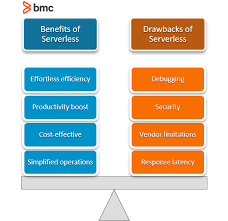
" width="300">

## container\my own computer benfit and drawback

<img src="https://i1.wp.com/transportgeography.org/wp-content/uploads/advantages_drawbacks_containerization.png?resize=900%2C523&ssl=1" width="750">

##  base on lacture & the pro & con images we loaded:
* this approach is not efficient because:
    * time consume - all the data transsfer from local computer to the cloud and back, each transfer of data cost us in time which is one of the most important thing in applications
    * debug abilities - in our computer we can debug the run, however we canot access all info from se
    verless run (cloud issues ...)
    * security issues - because we transfer data in between differenet part in the data process, we are expoused to data\knowledge leakage (cyber attacks) 
* this approach is efficient because:
    * the suffle operation is simple, more effiecent is to give to severless, complecated task.
    * debug abilities - in our computer we can debug the run.
    * costs manners - the use of cloud may const per use, if we will run all tasks on the cloud it will be expensive. 

<br><br>
**2. Suggest how can you improve shuffle so intermediate data will not be downloaded to the client at all and shuffle performed in the cloud as well. Explain pros and cons of the approaches you suggest.**


* we can improve shuffle so intermediate data will not be downloaded to the client at all and shuffle performed in the cloud as well by:
    * run all excersize 2 on the cloud 
    * running map --> suffle --> reduce on the cloud in a row, and return results

* pro for shuffling on cloud 
    * no need to parse cloud results, only get final results
    * free up client computer resouces.
* cons for shuffling on cloud 
    * it is hard to debug the suffling in the cloud
    * the cloud may be strong device, the suffuling operation is simple task, therefore we wast it power for simple task
    * the cloud may be buzzy, therefore task long time for simple task
    

<br><br>
**3. Can you make serverless shuffle?**


# Answer
* seteverless can do any job we demand, therefore yes severless can suffle
* we can load the map result before the suffle stage, however it is not effiect to do this

<br><br><br><br>
Good Luck :) 